In [ ]:
from transformers import pipeline

# Load the zero-shot classification pipeline with a model similar to BERT (RoBERTa-large-mnli)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define severity levels as possible labels
labels = ["Very Low", "Low", "Moderate", "High", "Very High"]

# Example medical report (replace this with your actual text data)
example_report = """
THE PATIENT'S ATTORNEY ALLEGED A DEFICIENCY AGAINST THE DEVICE RESULTING IN AN UNSPECIFIED ADVERSE OUTCOME.
THE PROCEDURE PERFORMED WAS A TOTAL VAGINAL HYSTERECTOMY WITH MESH IMPLANT, AND CYSTOSCOPY.
"""

# Perform zero-shot classification on the medical report
result = classifier(example_report, candidate_labels=labels)

# Display the most probable severity level
print(f"Predicted severity level: {result['labels'][0]}")


In [13]:
example_report = """
"(B)(4). IF INFORMATION IS PROVIDED IN THE FUTURE, A SUPPLEMENTAL REPORT WILL BE ISSUED."
"""

In [15]:
labels = ["Lowest severity", "Mild severity", "Moderate severity", "High severity", "Most severe"]

# Perform zero-shot classification on the medical report
result = classifier(example_report, candidate_labels=labels)

# Display the most probable severity level
print(f"Predicted severity level: {result['labels'][0]}")

Predicted severity level: Mild severity


In [2]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
import pandas as pd

In [3]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', timeout=60)  # Increase timeout
model = BertModel.from_pretrained('bert-base-uncased')


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [ ]:
# Function to get BERT embeddings for a given text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()  # Mean of token embeddings

# Load your dataset (replace with actual file path)
data = pd.read_csv("./data/stress_urinary_incontinence.csv")

# Get BERT embeddings for each text entry in the dataset
embeddings = np.array([get_bert_embedding(text) for text in data['FOI_TEXT']])

# Apply K-Means clustering (5 clusters for 5 severity levels)
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(embeddings)




In [16]:
num_clusters = 5
for cluster in range(num_clusters):
    print(f"Cluster {cluster}:")
    print(data[data['cluster'] == cluster]['FOI_TEXT'].sample(5, random_state=42).tolist())
    print("\n")

Cluster 0:
['IT WAS REPORTED TO BOSTON SCIENTIFIC CORPORATION THAT A ADVANTAGE WAS IMPLANTED INTO THE PATIENT ON (B)(6) 2007. THE PATIENT EXPERIENCED COMPLICATIONS, FURTHER SURGERY, AND NONSURGICAL TREATMENT. PATIENT SYMPTOMS INCLUDE: BACK PAIN; THI PAIN; OFF VAG DIS; DIFF BOWEL; REC INCONT; AGGRAV INCONT; PSYCH; OTH PAIN: LEG WEAKNESS, STOMACH AREA. NONSURGICAL TREATMENTS: THE PATIENT WAS TREATED WITH PAIN MEDICATION. THE PATIENT WAS TREATED WITH OTHER MEDICATION (PLEASE SPECIFY): ANTIBIOTICS (CONSTANT USE) FOR THE TREATMENT OF: BLADDER INFECTIONS. ON (B)(6) 2007 THE PATIENT COMMENCED PHYSIOTHERAPY TREATMENT (INCLUDING PELVIC FLOOR EXERCISES OR TRAINING). TREATMENT DURATION: SLOW DOWN AFTER 2015 . THE PATIENT WAS TREATED WITH TOPICAL TREATMENT (INCLUDING OESTROGEN CREAM).', 'NOTE: TWO BOSTON SCIENTIFIC MESH DEVICES WERE IMPLANTED INTO THE SAME PATIENT. THIS REPORT PERTAINS TO THE ADVANTAGE FIT. IT WAS REPORTED TO BOSTON SCIENTIFIC CORPORATION THAT AN ADVANTAGE FIT SLING AND A PINNACLE

In [ ]:
# Map clusters to severity levels manually based on the cluster characteristics
cluster_to_severity = {0: 'Lowest severity', 1: 'Mild severity', 2: 'Moderate severity', 3: 'High severity', 4: 'Most severe'}
data['severity_label'] = data['cluster'].map(cluster_to_severity)

# Save the labeled dataset to a CSV file
data.to_csv('clustered_maude_data.csv', index=False)

# Display the severity levels assigned to a sample of the dataset
print(data[['cleaned_text', 'severity_label']].head())

In [7]:
data = pd.read_csv("./data/clustered_maude_data.csv")

In [9]:
data.head()

,Unnamed: 0,MDR_REPORT_KEY,MDR_TEXT_KEY,TEXT_TYPE_CODE,PATIENT_SEQUENCE_NUMBER,DATE_REPORT,FOI_TEXT,DEVICE_EVENT_KEY,IMPLANT_FLAG,DATE_REMOVED_FLAG,...,DEVICE_AVAILABILITY,DATE_RETURNED_TO_MANUFACTURER,DEVICE_REPORT_PRODUCT_CODE,DEVICE_AGE_TEXT,DEVICE_EVALUATED_BY_MANUFACTUR,COMBINATION_PRODUCT_FLAG,UDI-DI,UDI-PUBLIC,cluster,severity_label
0,106741,6383024,106903842,N,1,NaN,BASED ON ADDITIONAL INFORMATION RECEIVED THIS ...,NaN,NaN,NaN,...,N,NaN,OTN,DA,N,N,NaN,NaN,2,Moderate severity
1,106742,6383024,106903843,D,1,NaN,BASED ON ADDITIONAL INFORMATION RECEIVED THIS ...,NaN,NaN,NaN,...,N,NaN,OTN,DA,N,N,NaN,NaN,2,Moderate severity
2,144133,6383024,109652829,N,1,NaN,"IF INFORMATION IS PROVIDED IN THE FUTURE, A SU...",NaN,NaN,NaN,...,N,NaN,OTN,DA,N,N,NaN,NaN,4,Most severe
3,703424,6383024,69202956,N,1,NaN,MANUFACTURER REFERENCE NUMBER: (B)(4). INCIDEN...,NaN,NaN,NaN,...,N,NaN,OTN,DA,N,N,NaN,NaN,2,Moderate severity
4,703425,6383024,69202957,D,1,NaN,THE PATIENT'S ATTORNEY ALLEGED A DEFICIENCY AG...,NaN,NaN,NaN,...,N,NaN,OTN,DA,N,N,NaN,NaN,0,Lowest severity


In [ ]:
data['cluster'] = kmeans.fit_predict(embeddings)

In [24]:
embeddings = np.vstack(embeddings)

In [25]:
data['cluster'] = kmeans.fit_predict(embeddings)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
cluster_to_severity = {4: 'Lowest severity', 3: 'Mild severity', 2: 'Moderate severity', 1: 'High severity', 0: 'Most severe'}
data['severity_label'] = data['cluster'].map(cluster_to_severity)

print(data[['FOI_TEXT', 'severity_label']].head())
# Save the labeled dataset to a CSV file
data.to_csv('./data/clustered_maude_data.csv', index=False)

# Display the severity levels assigned to a sample of the dataset

                                            FOI_TEXT     severity_label
0  BASED ON ADDITIONAL INFORMATION RECEIVED THIS ...  Moderate severity
1  BASED ON ADDITIONAL INFORMATION RECEIVED THIS ...  Moderate severity
2  IF INFORMATION IS PROVIDED IN THE FUTURE, A SU...        Most severe
3  MANUFACTURER REFERENCE NUMBER: (B)(4). INCIDEN...  Moderate severity
4  THE PATIENT'S ATTORNEY ALLEGED A DEFICIENCY AG...    Lowest severity


train

In [5]:
from sklearn.model_selection import train_test_split

In [6]:

# Load your dataset (replace with actual file path)
data = pd.read_csv('./data/clustered_maude_data.csv')

# Map severity labels to numeric values
severity_to_label = {
    'Lowest severity': 4,
    'Mild severity': 3,
    'Moderate severity': 2,
    'High severity': 1,
    'Most severe': 0
}
data['label'] = data['severity_label'].map(severity_to_label)

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['FOI_TEXT'].tolist(), 
    data['label'].tolist(), 
    test_size=0.2, 
    random_state=42
)

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)

# Convert to PyTorch Dataset format
class MAUDEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MAUDEDataset(train_encodings, train_labels)
val_dataset = MAUDEDataset(val_encodings, val_labels)


In [7]:
from transformers import DistilBertForSequenceClassification

# Load pre-trained DistilBERT model for classification with 5 labels
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    accuracy = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',             # Output directory
    evaluation_strategy="epoch",        # Evaluate after each epoch
    per_device_train_batch_size=32,     # Larger batch size for faster training
    per_device_eval_batch_size=64,      # Larger batch size for evaluation
    num_train_epochs=2,                 # Reduce number of epochs
    weight_decay=0.01,                  # Regularization
    logging_dir='./logs',               # Log directory
    logging_steps=10,                   # Log every 10 steps
    save_total_limit=2,                 # Keep only last 2 checkpoints
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # The DistilBERT model
    args=training_args,                  # Training arguments
    train_dataset=train_dataset,         # Training dataset
    eval_dataset=val_dataset,             # Validation dataset
    compute_metrics=compute_metrics
)


In [ ]:
# Train the model
trainer.train()

eval_results = trainer.evaluate()

print("Evaluation Results:", eval_results)

# Save the model after training
model.save_pretrained('./fine_tuned_distilbert_severity_model_new')



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions from the validation dataset
predictions = trainer.predict(val_dataset)

# Extract the predicted labels and actual labels
preds = predictions.predictions.argmax(-1)
true_labels = predictions.label_ids

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=severity_to_label.keys(), yticklabels=severity_to_label.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [8]:
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Load the model and tokenizer
model = DistilBertForSequenceClassification.from_pretrained('./fine_tuned_distilbert_severity_model')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Set the model to evaluation mode and move it to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the model is in evaluation mode
#  model.eval()

# Function to tokenize the dataset and convert it to PyTorch format
def encode_texts(texts, tokenizer, max_length=512):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    return encodings

# Function to get predictions from the model
def get_predictions(model, val_encodings, tokenizer, device):
    # encodings = encode_texts(texts, tokenizer)
    input_ids = val_encodings['input_ids'].to(device)
    attention_mask = val_encodings['attention_mask'].to(device)

    # Get predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()

    return preds, labels

# Tokenize and predict on the validation set
val_preds, val_labels = get_predictions(model, val_encodings, tokenizer, device)

# Calculate accuracy
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy}")

# Build the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=severity_to_label.keys(), yticklabels=severity_to_label.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [10]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Import tqdm for progress bars

# Ensure the model is in evaluation mode
# model.eval()

# Function to tokenize the dataset and convert it to PyTorch format
def encode_texts(texts, tokenizer, max_length=512):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
    return encodings

# Function to get predictions from the model with tqdm progress bar
def get_predictions(model, texts, labels, tokenizer, device):
    preds = []
    encodings = encode_texts(texts, tokenizer)
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    # Use tqdm to track progress
    for i in tqdm(range(len(input_ids)), desc="Processing batches"):
        # Get predictions batch by batch
        with torch.no_grad():
            outputs = model(input_ids[i:i+1], attention_mask=attention_mask[i:i+1])
            logits = outputs.logits
            pred = torch.argmax(logits, dim=-1).cpu().numpy()
            preds.append(pred[0])

    return preds, labels




In [11]:
# Tokenize and predict on the validation set
val_preds, val_labels = get_predictions(model, val_texts, val_labels, tokenizer, device)

Processing batches: 100%|██████████| 1921/1921 [16:56<00:00,  1.89it/s]


Validation Accuracy: 0.2644456012493493


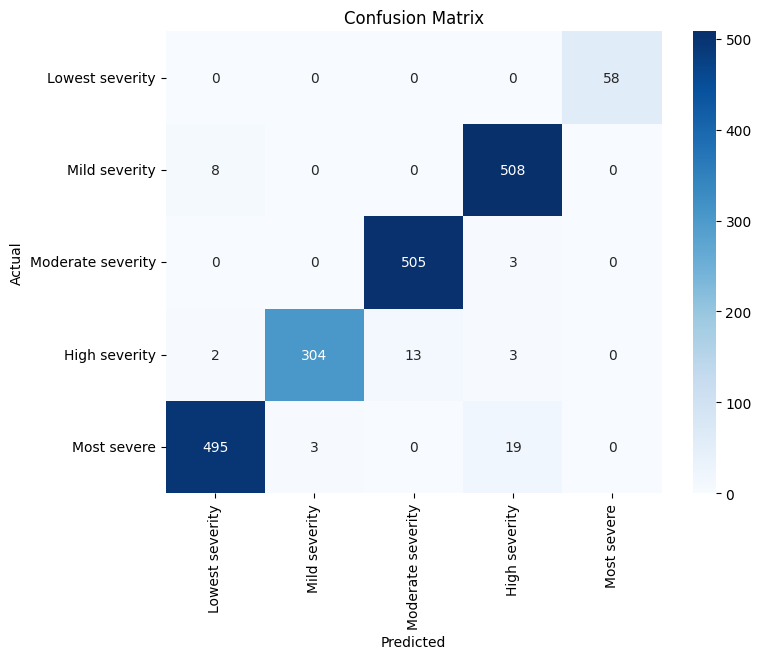

In [12]:
# Calculate accuracy
val_accuracy = accuracy_score(val_labels, val_preds)
print(f"Validation Accuracy: {val_accuracy}")

# Build the confusion matrix
conf_matrix = confusion_matrix(val_labels, val_preds)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=severity_to_label.keys(), yticklabels=severity_to_label.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [3]:
# New text data for prediction
new_texts = [
    "(B)(4). IF INFORMATION IS PROVIDED IN THE FUTURE, A SUPPLEMENTAL REPORT WILL BE ISSUED.",
    "There was an issue with the product, but it was resolved without any adverse outcomes.",
    "A malfunction occurred during the procedure, leading to a minor injury.",
    "The device has been reported to cause serious side effects, including organ damage.",
    "BASED ON ADDITIONAL INFORMATION RECEIVED THIS COMPLAINT IS NOT A MEDTRONIC PRODUCT. IF INFORMATION IS PROVIDED IN THE FUTURE, A SUPPLEMENTAL REPORT WILL BE ISSUED."
]

# Tokenize the new texts
new_encodings = tokenizer(new_texts, truncation=True, padding=True, max_length=256, return_tensors="pt")

# Move input tensors to the same device as the model
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}

# Make predictions
with torch.no_grad():
    outputs = model(**new_encodings)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Convert predictions back to severity labels
label_to_severity = {4: 'Lowest severity', 3: 'Mild severity', 2: 'Moderate severity', 1: 'High severity', 0: 'Most severe'}
predicted_severity = [label_to_severity[pred.item()] for pred in predictions]

print(predicted_severity)

['Lowest severity', 'Mild severity', 'Mild severity', 'Mild severity', 'Moderate severity']


In [ ]:
import torch

# Ensure the model is in evaluation mode
model.eval()

# Make predictions (no gradient computation needed during evaluation)
with torch.no_grad():
    outputs = model(**encodings)

# Get the predicted class labels
predictions = torch.argmax(outputs.logits, dim=-1)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [ ]:
# Map model output (integers) back to label names
label_mapping = {4: 'Lowest severity', 3: 'Mild severity', 2: 'Moderate severity', 1: 'High severity', 0: 'Most severe'}

predicted_labels = [label_mapping[p.item()] for p in predictions]


In [ ]:
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.2f}')


In [ ]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=list(label_mapping.values()))

# Display confusion matrix
ConfusionMatrixDisplay(conf_matrix, display_labels=list(label_mapping.values())).plot()


In [1]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load pre-trained T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained("ramsrigouthamg/t5_squad_v1")
tokenizer = T5Tokenizer.from_pretrained("ramsrigouthamg/t5_squad_v1")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/1.86k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [2]:
# Example context from medical report
context = "Patient reported experiencing severe abdominal pain and nausea after undergoing mesh implant surgery."

# Prepare input for the model
input_text = "Generate question: " + context
input_ids = tokenizer.encode(input_text, return_tensors="pt")

# Generate the question
outputs = model.generate(input_ids)
question = tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Generated question:", question)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/utils.py:1259: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Generated question: question: What was the result of the mesh implant surgery?
